In [ ]:
# Project Imports
!cp -r '/content/drive/Shareddrives/ECE 285/ConvexNN' .
from ConvexNN import ConvexVAE
from ConvexNN.models import ConvexReluMLP, NonConvexReLU
from ConvexNN.utils import sample_gate_vectors

In [ ]:
# General Imports
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
#from torchinfo import summary


In [ ]:
encoder_path = '/content/drive/Shareddrives/ECE 285/encoder.pt'
decoder_path = '/content/drive/Shareddrives/ECE 285/convex_decoder.pt'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
# Model Hyperparameters
x_dim  = 784
hidden_dim = 1024
latent_dim = 200

# Loading the class objects
encoder = ConvexVAE.Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_classes=10)
encoder.load_state_dict(torch.load(encoder_path))

decoder = ConvexReluMLP(d=latent_dim, num_neurons=hidden_dim, output_dims=784, num_classes=10)
decoder.load_state_dict(torch.load(decoder_path))

model = ConvexVAE.Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [ ]:
# loading in the data
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 1

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST('.', transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST('.', transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 246968773.73it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39139157.94it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 172217027.66it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7135029.50it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchmetrics[image]
from torchmetrics.image.inception import InceptionScore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Generating Synthetic data for the IS Scores

with torch.no_grad():

  # generating standard-normal noise
  standard_normal_noise = torch.randn(500,latent_dim).to(DEVICE)
  #standard_normal_noise = torch.zeros(500,latent_dim).to(DEVICE)
  print(standard_normal_noise.shape)
  # generating labels, make sure that the conditionals are perfectly uniform
  labels = torch.arange(0, 500) % 10
  labels = labels.to(DEVICE)
  print(labels.shape)
  # generating synthetic images
  synthetic_images = decoder.forward(standard_normal_noise,labels)
  print(synthetic_images.shape)
  # reshaping synthetic images into (batch_size, channel, width, height)
  synthetic_images = torch.reshape(synthetic_images,(500,1,28,28))
  print(synthetic_images.shape)
  # copying channels 3x to make fake grayscale
  synthetic_images = synthetic_images.repeat(1,3,1,1)
  # performing bilinear interpolation on images
  synthetic_images = torch.nn.functional.interpolate(synthetic_images,[299,299], mode='bilinear')
  print(synthetic_images.shape)
  # converting to uint8
  synthetic_images = synthetic_images * 255
  synthetic_images = synthetic_images.to(torch.uint8)

synthetic_images = synthetic_images.cpu()

torch.Size([500, 200])
torch.Size([500])
torch.Size([500, 784])
torch.Size([500, 1, 28, 28])
torch.Size([500, 3, 299, 299])


In [ ]:

inception = InceptionScore()
inception.update(synthetic_images)
IS = inception.compute()
print(IS)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


(tensor(2.3890), tensor(0.1240))


In [ ]:
synthetic_data_path = '/content/drive/Shareddrives/ECE 285/Purely_Synthetic_Data/'
real_data_path = '/content/drive/Shareddrives/ECE 285/MNIST_Interpolated/'

In [ ]:
# calculating FID scores
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
toPIL = transforms.ToPILImage()
for batch_idx, (x, y) in enumerate(test_loader):
  x = x.to(DEVICE)
  y = y.to(DEVICE)
  # generating reconstruction
  x_hat, _, _ = model(x,y)
  # reshaping images
  x = torch.reshape(x,(1,1,28,28))
  x_hat = torch.reshape(x_hat,(1,1,28,28))
  # repeating to mimic grayscale
  x = x.repeat(1,3,1,1)
  x_hat = x_hat.repeat(1,3,1,1)
  # performing bilinear interpolation
  x_interpolated = torch.nn.functional.interpolate(x,[299,299], mode='bilinear')
  x_hat_interpolated = torch.nn.functional.interpolate(x_hat,[299,299], mode='bilinear')
  # reducing the redundant batch dimension
  x_interpolated = x_interpolated[0,:,:,:]
  x_hat_interpolated = x_hat_interpolated[0,:,:,:]
  # converting to 0-255
  x_interpolated *= 255
  x_interpolated = x_interpolated.to(torch.uint8)
  x_hat_interpolated *= 255
  x_hat_interpolated = x_hat_interpolated.to(torch.uint8)
  # converting to PIL before saving
  x_interpolated = toPIL(x_interpolated)
  x_hat_interpolated = toPIL(x_hat_interpolated)
  # saving
  x_interpolated.save(real_data_path + str(batch_idx)+".png")
  x_hat_interpolated.save(synthetic_data_path + str(batch_idx)+".png")

In [ ]:
!python -m pytorch_fid '/content/drive/Shareddrives/ECE 285/MNIST_Interpolated/' '/content/drive/Shareddrives/ECE 285/Purely_Synthetic_Data/'

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:05<00:00, 17.9MB/s]
100% 200/200 [01:01<00:00,  3.24it/s]
100% 200/200 [01:00<00:00,  3.30it/s]
FID:  236.87055297753176


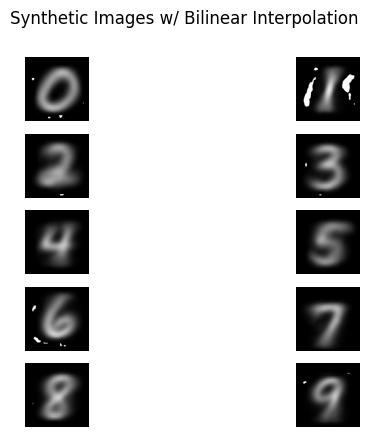

In [ ]:
# Synthetic Data Visual

for ndx in range(10):
  im = synthetic_images[ndx,:,:]
  im = im.permute(1,2,0)
  plt.subplot(5,2,ndx+1)
  plt.imshow(im,cmap='gray')
  plt.axis('off')
  plt.suptitle("Synthetic Images w/ Bilinear Interpolation")

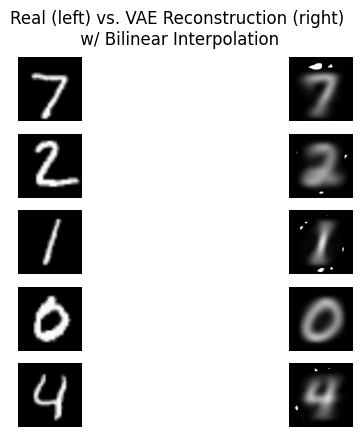

In [ ]:
for batch_idx, (x, y) in enumerate(test_loader):
  if batch_idx < 5:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    # generating reconstruction
    x_hat, _, _ = model(x,y)
    # reshaping images
    x = torch.reshape(x,(1,1,28,28))
    x_hat = torch.reshape(x_hat,(1,1,28,28))
    # repeating to mimic grayscale
    x = x.repeat(1,3,1,1)
    x_hat = x_hat.repeat(1,3,1,1)
    # performing bilinear interpolation
    x_interpolated = torch.nn.functional.interpolate(x,[299,299], mode='bilinear')
    x_hat_interpolated = torch.nn.functional.interpolate(x_hat,[299,299], mode='bilinear')
    # reducing the redundant batch dimension
    x_interpolated = x_interpolated[0,:,:,:]
    x_hat_interpolated = x_hat_interpolated[0,:,:,:]
    # converting to 0-255
    x_interpolated *= 255
    x_interpolated = x_interpolated.to(torch.uint8)
    x_hat_interpolated *= 255
    x_hat_interpolated = x_hat_interpolated.to(torch.uint8)
    # re-ordering
    x_interpolated = x_interpolated.permute(1,2,0).to('cpu')
    x_hat_interpolated = x_hat_interpolated.permute(1,2,0).to('cpu')
    #plotting
    plt.subplot(5,2,2*batch_idx+1)
    plt.imshow(x_interpolated,cmap='gray')
    plt.axis('off')
    plt.subplot(5,2,2*batch_idx+2)
    plt.imshow(x_hat_interpolated,cmap='gray')
    plt.axis('off')
    plt.suptitle("Real (left) vs. VAE Reconstruction (right)\n w/ Bilinear Interpolation")